In [12]:
import numpy as np
import torch
import torch.nn.functional as F
from transformers.optimization import AdamW
from transformers import BertTokenizerFast, BertModel, AutoModel
from torch.utils.data import DataLoader

from tqdm import tqdm

import random
import os
import model
import inference_utils
import dataset_utils
import utils
import pickle

import spacy
from sklearn.metrics import f1_score
from seqeval.metrics import classification_report
import train_utils
from train_utils import train_eval

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(42)

In [3]:
MAX_SEQ_LEN = 100
LABEL_LIST = ["O", "B-ASP", "I-ASP", "[CLS]", "[SEP]"]
label_map = {i: label for i, label in enumerate(LABEL_LIST, 1)}
THRESHOLD_SRD = 5
NUM_POL_CLASSES = 3
LCF = 'cdw'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LR = 2e-5
BATCH_SIZE = 8
N_EPOCHS = 60
DROPOUT_ATE = 0.1
DROPOUT_ASC = 0.1
DROPOUT_OUT = 0.1
WEIGHT_DECAY = 1e-5
MODEL_NAME = "bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)

In [4]:
train_data_14 = utils.read_train_test_files_new('./data/rests/Restaurants_2014.train.txt')
test_data_14 = utils.read_train_test_files_new('./data/rests/Restaurants_2014.test.txt')

train_data_15 = utils.read_train_test_files_new('./data/rests/Restaurants_2015.train.txt')
test_data_15 = utils.read_train_test_files_new('./data/rests/Restaurants_2015.test.txt')

train_data_16 = utils.read_train_test_files_new('./data/rests/Restaurants_2016.train.txt')
test_data_16 = utils.read_train_test_files_new('./data/rests/Restaurants_2016.test.txt')

all_test_data = test_data_14 + test_data_15 + test_data_16
all_train_data = train_data_14 + train_data_15 + train_data_16

unique_test_data = []
unique_train_data = []

for x in all_train_data:
    if x not in unique_train_data:
        unique_train_data.append(x)

for x in all_test_data:
    if x not in unique_test_data and x not in unique_train_data:
        unique_test_data.append(x)

In [17]:
train_dataset = dataset_utils.ATEPCDataset('train_test',
                                           'simple',
                                           [sample[0] for sample in unique_train_data],
                                           [sample[1] for sample in unique_train_data],
                                           [sample[2] for sample in unique_train_data],
                                           tokenizer,
                                           MAX_SEQ_LEN,
                                           THRESHOLD_SRD,
                                           'ru_core_news_sm')

test_dataset = dataset_utils.ATEPCDataset('train_test',
                                           'simple',
                                           [sample[0] for sample in unique_test_data],
                                           [sample[1] for sample in unique_test_data],
                                           [sample[2] for sample in unique_test_data],
                                           tokenizer,
                                           MAX_SEQ_LEN,
                                           THRESHOLD_SRD,
                                           'ru_core_news_sm')

In [18]:
len(train_dataset)

4811

In [7]:
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [4330, 481])

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
ATEPCNet = model.LCF_ATEPC(MODEL_NAME, 
                           False, 
                           True, 
                           DROPOUT_ATE, 
                           DROPOUT_ASC, 
                           DROPOUT_OUT,
                           MAX_SEQ_LEN, 
                           LCF, 
                           device, 
                           NUM_POL_CLASSES)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bi

In [10]:
ATEPCNet.to(device)
optimizer = AdamW(ATEPCNet.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
#optimizer = torch.optim.SGD(ATEPCNet.parameters(), lr=LR, weight_decay=WEIGHT_DECAY, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, N_EPOCHS)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

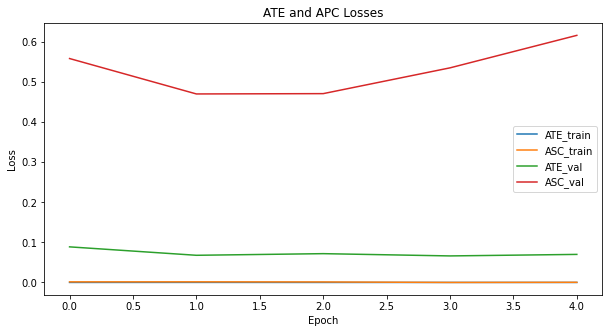

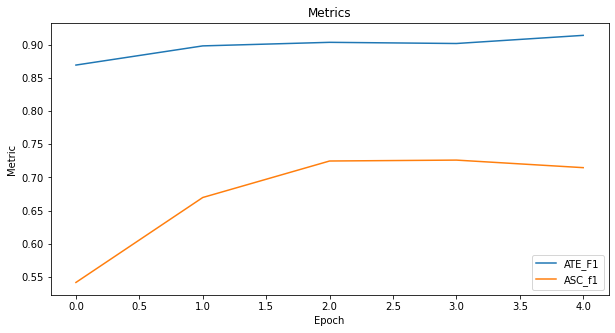

  8%|██████▋                                                                         | 5/60 [16:40<3:03:23, 200.06s/it]


KeyboardInterrupt: 

In [11]:
train_eval(ATEPCNet,
           train_dataloader,
           val_dataloader,
           optimizer,
           N_EPOCHS,
           './showcase.pt',
           scheduler,
           device,
           eval_ATE=True,
           eval_ASC=True)

In [15]:
ATEPCNet.load_state_dict(torch.load('./showcase.pt', map_location=device))
ATEPCNet.to(device)
_, _, f1_ATE, f1_ASC = train_utils.eval_loop(ATEPCNet, test_dataloader, eval_ATE=True, eval_ASC=True)
print(f1_ATE, f1_ASC)

0.8373293194280185 0.7304018847610031
